# Implementation of ATP
Credit to Naresh M. Patel for the Half-Latency Rule for Finding the Knee of the Latency Curve (https://dl.acm.org/doi/10.1145/2825236.2825248)

In [202]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.integrate as spi
import importlib
import utils.atp
importlib.reload(utils.atp)
from utils.atp import ATP
from numpy.polynomial.polynomial import Polynomial

data = pd.read_csv('output/12k_randrw/50/fio.csv').set_index('io_depth')
data.sort_index(inplace=True)

relative_importance_of_throughput = 1 # alpha in the paper
atp = ATP(data, alpha=relative_importance_of_throughput)
latency_curve = Polynomial.fit(x=data['total_throughput'], y=data['avg_latency'], deg=2, w=1/data['total_throughput']) # w(u)
throughput_x_range = np.linspace(data['total_throughput'].min(), data['total_throughput'].max(), 1000)
latency_y_range = latency_curve(throughput_x_range) # w(x) over the range 0,x
print(atp.data.sort_values(by='ATP', ascending=True)[['ATP', 'total_throughput', 'avg_latency']][:1])


               ATP  total_throughput  avg_latency
io_depth                                         
4        -0.003535             53910   888.277183
read_throughput                          26997
read_latency                        774.520874
read_iops                          2249.750244
write_throughput                         26913
write_latency                      1002.388184
write_iops                         2242.757324
read_percent                         50.077829
total_throughput                         53910
timestamp             Tue Mar 14 03:55:16 2023
duration                                     3
blocksize                                  12k
total_iops                         4492.507568
iops_latency_ratio                    0.005694
avg_latency                         888.277183
through_normalized                         1.0
ORT                           -15252357.409219
ATP                                  -0.003535
Name: 4, dtype: object


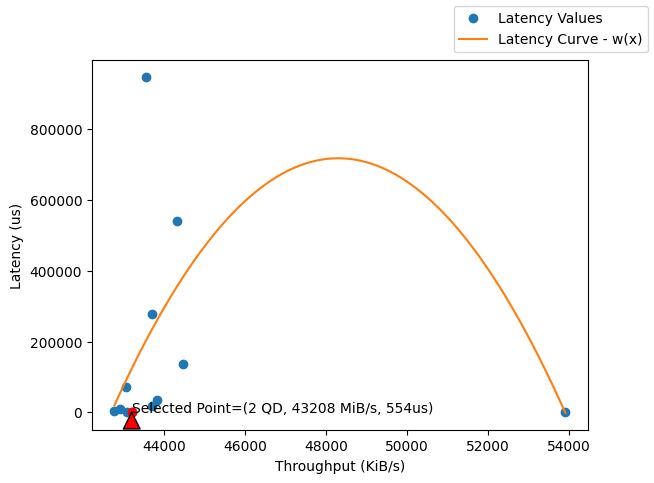

In [167]:
fig, ax1 = plt.subplots()

ax1.plot(data['total_throughput'], data['avg_latency'], 'o', label='Latency Values')
ax1.plot(throughput_x_range, latency_y_range, '-', label='Latency Curve - w(x)')
# ax1.plot(atp.data['total_throughput'], atp.data['ORT'] * 2, label='Doubled ORT Curve - 2*r(x)')

ax1.set_xlabel('Throughput (KiB/s)')
ax1.set_ylabel('Latency (us)')
ax1.tick_params(axis='y')

# print(latency_y_range[intersection_indices])
# Extract the x and y values of the intersection points
intersection_x_vals = atp.j['total_throughput']
intersection_y_vals = atp.j['avg_latency']
ax1.plot(intersection_x_vals, intersection_y_vals, 'ro')
ax1.annotate(f'Selected Point=({str(atp.j.name)} QD, {atp.j["total_throughput"]:.0f} MiB/s, {atp.j["avg_latency"]:.0f}us)',
              xy=(intersection_x_vals, intersection_y_vals), 
              xytext=(intersection_x_vals + .1, intersection_y_vals + 0.01), 
              arrowprops=dict(facecolor='red', shrink=0.05))


# ax2 = ax1.twinx()

# ax2.plot(throughput_x_range, response_time_vals, label='ORT Curve - r(x)')
# ax2.set_ylabel('Response Time (ms)')
# ax2.tick_params(axis='y')

fig.legend(loc='upper right')
# plt.show()



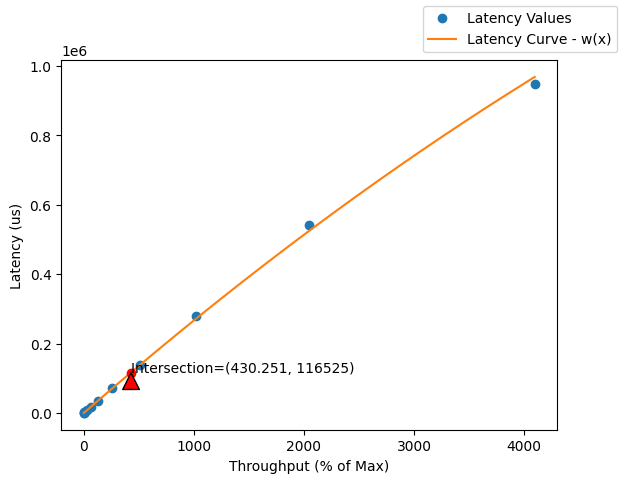

In [113]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.integrate as spi
import importlib
from numpy.polynomial.polynomial import Polynomial

example_data = pd.read_csv('output/12k_randrw/50/fio.csv').set_index('io_depth')
example_data.sort_index(inplace=True)
# throughput = example_data.total_throughput
# throughput = example_data.total_throughput / example_data.total_throughput.max()
# latency = example_data.avg_latency
# print(atp.__dict__)
# latency_y_vals = atp.calculate_latency_points()
# atp.do_the_math()
# print(atp.points_of_intersection)
# tolerance = 0.01
# intersection_indices = np.where(np.isclose(atp.latency_y_range, atp.ort_curve_y_range*2, rtol=tolerance))
# cqd = example_data[example_data['avg_latency'] <= atp.find_points_of_intersection()['y']]
# x_j = throughput[np.where(2*self.ort_curve_y_range - self.latency_y_range < 0)[0][0]]
# w_j = throughput[np.where(2*self.ort_curve_y_range - self.latency_y_range < 0)[0][0]]

# print(atp)
# ort_y_vals = np.array([atp.ORT(x=x, w=atp.latency_curve) for x in throughput])
# print(ort_y_vals)
# print(atp.ORT(x=10, w=atp.latency_curve))

# throughput = example_data.total_throughput
# throughput = example_data.total_throughput / example_data.total_throughput.max()
throughput = example_data.index
latency = example_data.avg_latency
x=0.715
relative_important_of_throughput = 1 # alpha in the paper

latency_curve = Polynomial.fit(x=throughput, y=latency, deg=2, w=1/throughput) # w(u)
throughput_x_range = np.linspace(throughput.min(), throughput.max(), 1000)
latency_y_range = latency_curve(throughput_x_range) # w(x) over the range 0,x

def r(x:float , curve) -> float:
    """
    Computes the integral (1 / x) * integral(from 0 to x) of { w(u) du }
    
    Args:
    x (float): upper limit of integration
    w (function): a function that returns the value of w(u) for a given u
    
    Returns:
    The value of the integral
    """

    numerator, abserr= spi.quad(curve, 0, x)
    denominator = x
    return numerator / denominator

response_time_vals = np.array([r(x=x, curve=latency_curve) for x in throughput_x_range])

# Find the value of latency_mathed at x% of the way along the line

# Plot the throughput/latency curve and the response time curve
fig, ax1 = plt.subplots()

ax1.plot(throughput, latency, 'o', label='Latency Values')
ax1.plot(throughput_x_range, latency_y_range, '-', label='Latency Curve - w(x)')
# ax1.plot(throughput_x_range, response_time_vals*2, label='Doubled ORT Curve - 2*r(x)')

ax1.set_xlabel('Throughput (% of Max)')
ax1.set_ylabel('Latency (us)')
ax1.tick_params(axis='y')

# Plot the point on the latency curve at x
# x_val = x * (throughput_x_range.max() - throughput_x_range.min()) + throughput_x_range.min()
# y_val = latency_curve(x_val)
# ax1.plot(x_val, y_val, 'ro')
# ax1.annotate(f'f(x)=({x_val:.3f}, {y_val:.0f})', 
#              xy=(x_val, y_val), 
#              xytext=(x_val + .1, y_val + 0.01), 
#              arrowprops=dict(facecolor='black', shrink=0.05))

# Interpolate response_time_vals onto the x-values of latency_mathed
response_time_interp = np.interp(throughput_x_range, throughput_x_range, response_time_vals)


# Find the indices of the points of intersection
intersection_indices = np.where(np.isclose(latency_y_range, response_time_interp*2, rtol=0.01))
# print(latency_y_range[intersection_indices])
# Extract the x and y values of the intersection points
intersection_x_vals = np.average(throughput_x_range[intersection_indices])
intersection_y_vals = np.average(latency_y_range[intersection_indices])
ax1.plot(intersection_x_vals, intersection_y_vals, 'ro')
ax1.annotate(f'Intersection=({intersection_x_vals:.3f}, {intersection_y_vals:.0f})',
              xy=(intersection_x_vals, intersection_y_vals), 
              xytext=(intersection_x_vals + .1, intersection_y_vals + 0.01), 
              arrowprops=dict(facecolor='red', shrink=0.05))


# ax2 = ax1.twinx()

# ax2.plot(throughput_x_range, response_time_vals, label='ORT Curve - r(x)')
# ax2.set_ylabel('Response Time (ms)')
# ax2.tick_params(axis='y')

fig.legend(loc='upper right')
# plt.show()

In [10]:
print(response_time_vals)


[1239.1314352  1237.73887684 1236.35102577 1234.967882   1233.58944554
 1232.21571637 1230.84669451 1229.48237994 1228.12277267 1226.7678727
 1225.41768004 1224.07219467 1222.7314166  1221.39534583 1220.06398236
 1218.73732619 1217.41537732 1216.09813575 1214.78560148 1213.47777451
 1212.17465484 1210.87624247 1209.5825374  1208.29353963 1207.00924915
 1205.72966598 1204.45479011 1203.18462154 1201.91916026 1200.65840629
 1199.40235962 1198.15102024 1196.90438817 1195.66246339 1194.42524592
 1193.19273574 1191.96493287 1190.74183729 1189.52344901 1188.30976804
 1187.10079436 1185.89652798 1184.6969689  1183.50211713 1182.31197265
 1181.12653547 1179.94580559 1178.76978301 1177.59846773 1176.43185975
 1175.26995907 1174.11276569 1172.96027961 1171.81250083 1170.66942935
 1169.53106517 1168.39740829 1167.2684587  1166.14421642 1165.02468144
 1163.90985375 1162.79973337 1161.69432029 1160.5936145  1159.49761602
 1158.40632483 1157.31974095 1156.23786436 1155.16069508 1154.08823309
 1153.0

In [2]:

latency_curve = np.polynomial.polynomial.Polynomial.fit(x=throughput, y=latency, deg=2, w=1/throughput) # w(x) in the paper 
area_under_latency_curve = latency_curve.integ()                                                        # a(x) in the paper

# response_time = area_under_latency_curve(x)                                                             # r(x) in the paper
# response_time = latency_curve(x)                                                             # r(x) in the paper

def overall_response_time(throughput: list, latency: list, x_val: int):
    """
    Calculate the overall response time for a given throughput and latency.
    """
    latency_curve = np.polynomial.polynomial.Polynomial.fit(x=throughput, y=latency, deg=2, w=1/throughput)     # w(x) in the paper 
    area_under_latency_curve = latency_curve.integ()                                                            # a(x) in the paper 
    response_time = area_under_latency_curve(x_val) / x_val                                                    # r(x) in the paper
    return response_time

def accelerated_throughput_power(x_val: int, relative_important_of_throughput: int = 1):
    return (x_val**(1+relative_important_of_throughput) / (area_under_latency_curve(x_val)))

ORT = overall_response_time(throughput, latency, throughput.max())

ATP = accelerated_throughput_power(throughput.max())  

print(f'Latency curve Polynomial: {latency_curve} \n Integral of Latency Curve: {area_under_latency_curve} \n Overall Response Time: {ORT} \n ATP: {ATP}')



Latency curve Polynomial: 1765.1663874029546 + 2517.962436219453·x¹ + 1761.7086751494069·x² 
 Integral of Latency Curve: 0.0 + 757.4475419528011·x¹ + 540.2392861247386·x² + 251.98793631236023·x³ 
 Overall Response Time: 1549.6747643898998 
 ATP: 0.0006452966925570964


In [3]:
throughput_x_range = np.linspace(throughput.min(), throughput.max(), 100)
latency_mathed = latency_curve(throughput_x_range)


# Find the value of latency_mathed at x% of the way along the line
point_idx = int(x * len(latency_mathed))
x_val = throughput_x_range[point_idx]
y_val = latency_mathed[point_idx]

response_time_vals = [overall_response_time(throughput=throughput_x_range, latency=latency_mathed, x_val=x) for x in throughput_x_range]

print(response_time_vals)

[-3309.246149638944, -3061.011091111841, -2840.8517861035766, -2644.3423471267697, -2467.9266051610157, -2308.714480922919, -2164.333008130055, -2032.815628718253, -1912.5187602902502, -1802.0581066341258, -1700.2594675667838, -1606.1203378689281, -1518.7796318545888, -1437.4935959671964, -1361.6164824386358, -1290.5849211213122, -1223.9051894062288, -1161.142772033374, -1101.9137442243316, -1045.8776171393283, -992.7313640982229, -942.2044063035471, -894.0543829534148, -848.0635662281014, -804.0358092915337, -761.7939370874067, -721.1775067502296, -682.0408779547942, -644.2515442908715, -607.688685377463, -572.2419063834101, -537.8101372523062, -504.3006685127253, -471.6283043021175, -439.7146163103098, -408.48728488678404, -377.8795156578211, -347.82952174695396, -318.2800631502198, -289.1780360386755, -260.47410578663977, -232.12237838911813, -204.08010566345476, -176.30742025092678, -148.76709696209033, -121.42433746034746, -94.24657566379295, -67.20330157622412, -40.26590154276503

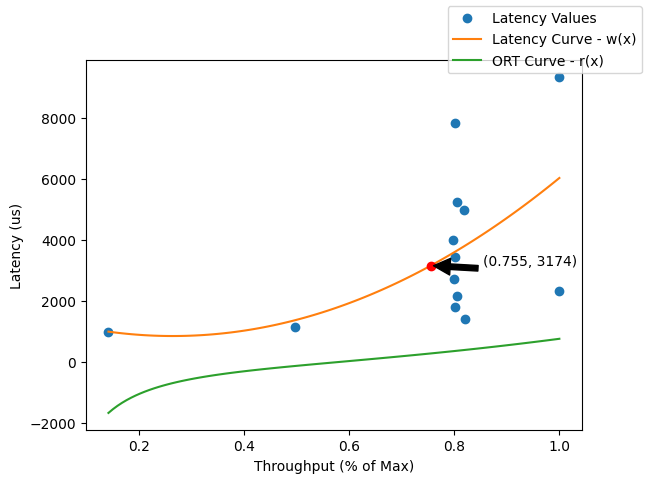

In [73]:
throughput_x_range = np.linspace(throughput.min(), throughput.max(), 100)
latency_mathed = latency_curve(throughput_x_range)


# Find the value of latency_mathed at x% of the way along the line
point_idx = int(x * len(latency_mathed))
x_val = throughput_x_range[point_idx]
y_val = latency_mathed[point_idx]

response_time_vals = [overall_response_time(throughput_x_range, latency_mathed, x)/2 for x in throughput_x_range]

# Plot the throughput/latency curve and the response time curve
fig, ax1 = plt.subplots()


ax1.plot(throughput, latency, 'o', label='Latency Values')
ax1.plot(throughput_x_range, latency_mathed, '-', label='Latency Curve - w(x)')
ax1.set_xlabel('Throughput (% of Max)')
ax1.set_ylabel('Latency (us)')
ax1.tick_params(axis='y')

x_val = x * (throughput_x_range.max() - throughput_x_range.min()) + throughput_x_range.min()
y_val = latency_curve(x_val)
ax1.plot(x_val, y_val, 'ro')
ax1.annotate(f'({x_val:.3f}, {y_val:.0f})', xy=(x_val, y_val), xytext=(x_val + .1, y_val + 0.01), arrowprops=dict(facecolor='black', shrink=0.05))


# ax2 = ax1.twinx()

ax1.plot(throughput_x_range, response_time_vals, label='ORT Curve - r(x)')
# ax2.set_ylabel('Response Time (ms)')
# ax2.tick_params(axis='y')

fig.legend(loc='upper right')
plt.show()



